In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [8]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 620ms/step - loss: 73.2800 - mae: 73.6896
Epoch 2/100
8/8 [==============================] - 0s 48ms/step - loss: 72.6322 - mae: 72.9788
Epoch 3/100
8/8 [==============================] - 0s 46ms/step - loss: 71.4605 - mae: 71.8377
Epoch 4/100
8/8 [==============================] - 0s 46ms/step - loss: 70.0359 - mae: 70.4184
Epoch 5/100
8/8 [==============================] - 0s 47ms/step - loss: 68.2689 - mae: 68.7583
Epoch 6/100
8/8 [==============================] - 0s 47ms/step - loss: 66.4883 - mae: 66.8782
Epoch 7/100
8/8 [==============================] - 0s 47ms/step - loss: 64.2616 - mae: 64.7354
Epoch 8/100
8/8 [==============================] - 0s 47ms/step - loss: 62.0457 - mae: 62.3713
Epoch 9/100
8/8 [==============================] - 0s 48ms/step - loss: 59.3746 - mae: 59.7458
Epoch 10/100
8/8 [==============================] - 0s 48ms/step - loss: 56.3313 - mae: 56.8317
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 0s 47ms/step - loss: 10.9255 - mae: 11.6367
Epoch 88/100
8/8 [==============================] - 0s 48ms/step - loss: 11.3700 - mae: 12.0015
Epoch 89/100
8/8 [==============================] - 0s 47ms/step - loss: 11.7735 - mae: 13.4100
Epoch 90/100
8/8 [==============================] - 0s 48ms/step - loss: 28.7528 - mae: 29.0607
Epoch 91/100
8/8 [==============================] - 0s 46ms/step - loss: 15.4962 - mae: 15.5951
Epoch 92/100
8/8 [==============================] - 0s 48ms/step - loss: 22.9931 - mae: 22.6299
Epoch 93/100
8/8 [==============================] - 0s 47ms/step - loss: 26.1823 - mae: 25.7465
Epoch 94/100
8/8 [==============================] - 0s 48ms/step - loss: 17.5895 - mae: 17.6440
Epoch 95/100
8/8 [==============================] - 0s 48ms/step - loss: 14.2346 - mae: 14.4800
Epoch 96/100
8/8 [==============================] - 0s 47ms/step - loss: 20.0196 - mae: 20.1561
Epoch 97/100
8/8 [==============================] - 0

[1e-08, 0.0001, 0, 30]

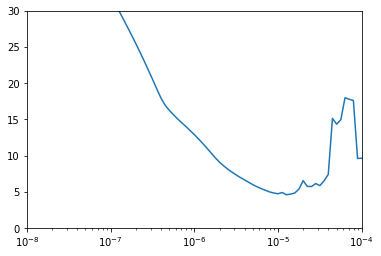

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 4s 116ms/step - loss: 21.5713 - mae: 22.3311
Epoch 2/500
31/31 [==============================] - 1s 31ms/step - loss: 8.2302 - mae: 8.7146
Epoch 3/500
31/31 [==============================] - 1s 32ms/step - loss: 6.6533 - mae: 7.1294
Epoch 4/500
31/31 [==============================] - 1s 32ms/step - loss: 6.5045 - mae: 6.9897
Epoch 5/500
31/31 [==============================] - 1s 33ms/step - loss: 5.9441 - mae: 6.4212
Epoch 6/500
31/31 [==============================] - 1s 32ms/step - loss: 5.5678 - mae: 6.0458
Epoch 7/500
31/31 [==============================] - 1s 32ms/step - loss: 5.3540 - mae: 5.8331
Epoch 8/500
31/31 [==============================] - 1s 33ms/step - loss: 5.2692 - mae: 5.7491
Epoch 9/500
31/31 [==============================] - 1s 33ms/step - loss: 5.2261 - mae: 5.6994
Epoch 10/500
31/31 [==============================] - 1s 34ms/step - loss: 5.2973 - mae: 5.7732
Epoch 11/500
31/31 [==========================

KeyboardInterrupt: 

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()